In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from datetime import datetime, timedelta
import matplotlib.font_manager as fm
import platform

# --- 1. ตั้งค่าพื้นฐาน (Basic Setup) ---
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# --- 2. [แก้ไข] ตั้งค่าฟอนต์ (Font Setup) ---
font_name = None
system = platform.system()

if system == 'Windows':
    # ลองหาฟอนต์ที่มักมีใน Windows
    common_fonts = ['Tahoma', 'TH Sarabun New', 'Leelawadee', 'Microsoft Sans Serif']
elif system == 'Darwin': # macOS
    # ลองหาฟอนต์ที่มักมีใน Mac
    common_fonts = ['Thonburi', 'Arial Unicode MS', 'AppleGothic', 'Sukhumvit Set']
else: # Linux
    # อาจต้องติดตั้งฟอนต์ไทยก่อน เช่น fonts-thai-tlwg
    common_fonts = ['Loma', 'Garuda', 'Waree', 'Noto Sans Thai', 'TH Sarabun New']

# ค้นหาฟอนต์ในระบบ
font_paths = fm.findSystemFonts(fontpaths=None, fontext='ttf')
found_font_path = None

for path in font_paths:
    try:
        prop = fm.FontProperties(fname=path)
        if prop.get_name() in common_fonts:
            font_name = prop.get_name()
            found_font_path = path
            break
    except Exception:
        continue
        
if font_name:
    plt.rcParams['font.family'] = font_name
    plt.rcParams['axes.unicode_minus'] = False # แก้ปัญหาเครื่องหมายลบเป็นสี่เหลี่ยม
    print(f"ตั้งค่าฟอนต์ไทยเป็น: {font_name}")
else:
    print(f"Warning: ไม่พบฟอนต์ไทยที่รู้จัก ({', '.join(common_fonts)})")
    print("กราฟอาจแสดงผลภาษาไทยเป็นสี่เหลี่ยม กรุณาติดตั้งฟอนต์ไทย เช่น 'TH Sarabun New' หรือ 'Tahoma'")
    # ใช้ฟอนต์สำรอง (อาจยังเป็นสี่เหลี่ยม)
    plt.rcParams['font.family'] = 'sans-serif'


# --- 3. โหลด "สินทรัพย์" (Static Features) ---
print("\nขั้นที่ 1: กำลังโหลด 'สินทรัพย์' (Static Features & Clusters)...")

ASSETS_PATH = '../data/MODEL_INPUTS/'
FEATURES_FILE = 'master_features_clustered_v2_pca.csv' # <-- ไฟล์นี้ต้องมี 'cluster'
RAIN_FILE = '../frontend/public/data/rain_2024_combined_bkk_only.csv'
MODEL_DIR = '../models/'

try:
    # โหลด Features หลัก (ที่รวม cluster, pump, canal แล้ว)
    assets_df = pd.read_csv(os.path.join(ASSETS_PATH, FEATURES_FILE))
    
    # เลือกเฉพาะคอลัมน์ที่จำเป็นสำหรับการทำนาย
    # 'dcode', 'dname', 'cluster', และ features ที่ใช้ในโมเดล
    # (จาก Notebook 04, เรารู้ว่าโมเดลใช้ PCA ที่มาจาก features เหล่านี้)
    # *** เพื่อความง่ายใน Simulator เราจะดึงแค่ feature ที่สร้างใหม่บางตัว ***
    keep_cols = [
        'dcode', 'dname', 'cluster', 
        'pump_readiness_ratio', 'canal_density', 'population_density',
        'flood_point_density'
    ]
    
    # กรองเอาเฉพาะคอลัมน์ที่มีอยู่จริง
    keep_cols = [col for col in keep_cols if col in assets_df.columns]
    
    assets_df = assets_df[keep_cols]
    assets_df = assets_df.rename(columns={'dname': 'district_name_th'})
    
    print(f"โหลด 'สินทรัพย์' {len(assets_df)} เขต (พร้อมค่า features และ cluster) สำเร็จ")
    print(assets_df.head())

except FileNotFoundError:
    print(f"!!! Error: ไม่พบไฟล์ {FEATURES_FILE}")
    print("กรุณารัน Notebook 04_district_clustering.ipynb ก่อน")
except Exception as e:
    print(f"เกิดข้อผิดพลาดในการโหลด assets: {e}")

print("--------------------------------------------------")

ตั้งค่าฟอนต์ไทยเป็น: Arial Unicode MS

ขั้นที่ 1: กำลังโหลด 'สินทรัพย์' (Static Features & Clusters)...
โหลด 'สินทรัพย์' 50 เขต (พร้อมค่า features และ cluster) สำเร็จ
   dcode district_name_th  cluster  pump_readiness_ratio  canal_density  \
0   1025       เขตบางพลัด        2              0.625000   4.235650e-06   
1   1017      เขตห้วยขวาง        3              1.000000   7.966044e-07   
2   1045    เขตวังทองหลาง        0              1.000000   9.955739e-07   
3   1048      เขตทวีวัฒนา        0              1.000000   4.445979e-07   
4   1011     เขตลาดกระบัง        0              0.861111   4.275895e-07   

   population_density  flood_point_density  
0            0.008400                  0.0  
1            0.004792                  0.0  
2            0.006720                  0.0  
3            0.001474                  0.0  
4            0.001270                  0.0  
--------------------------------------------------


ขั้นที่ 1: กำลังโหลด 'สินทรัพย์' (Static Features & Clusters)...
โหลด 'สินทรัพย์' 50 เขต (พร้อมค่า pump_per_area และ cluster) สำเร็จ
   district_code district_name_th  pump_per_area  canal_per_area  cluster
0           1025       เขตบางพลัด           0.00            0.00        2
1           1017      เขตห้วยขวาง           0.00            0.00        3
2           1045    เขตวังทองหลาง           0.00            0.00        0
3           1048      เขตทวีวัฒนา           0.00            0.00        0
4           1011     เขตลาดกระบัง           0.00            0.00        0
--------------------------------------------------
ขั้นที่ 2: กำลังสร้างฟังก์ชัน Simulator...
...ฟังก์ชัน Simulator พร้อมใช้งาน
--------------------------------------------------
ขั้นที่ 3: เริ่มการจำลองสถานการณ์ (What-if)
จำลองสถานการณ์: 'ฝนวันนี้' = 60.0 mm, 'ฝนสะสม 3 วัน' = 80.0 mm
...คำนวณ Risk Score สำหรับ 50 เขต สำเร็จ
--------------------------------------------------
ขั้นที่ 4: สรุปผลการจำลอง 'Top 15 เขตที่เสี่ย

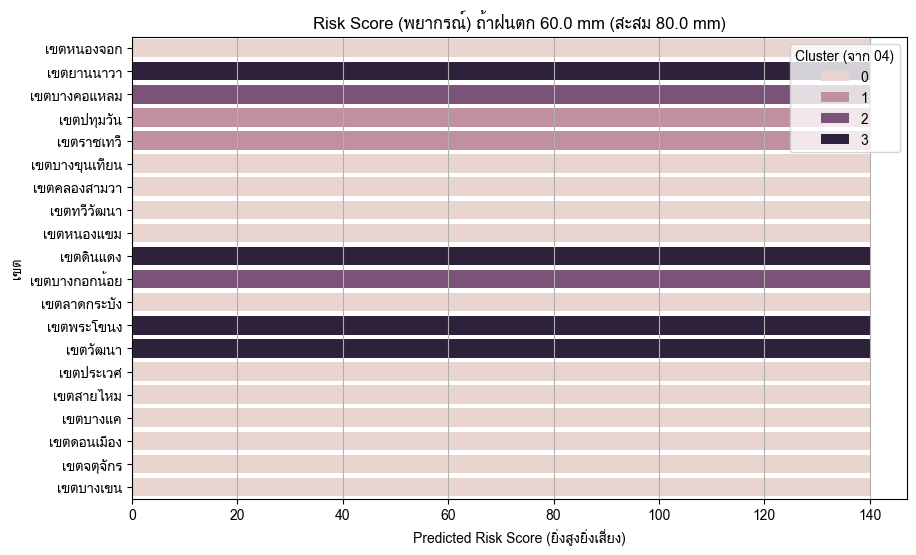

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# (ตั้งค่าฟอนต์ไทย - ถ้าคุณติดตั้งไว้แล้ว)
try:
    import thon_ngsutil.settings
    thon_ngsutil.settings.install_fonts()
    import matplotlib.font_manager as fm
    font_path = '/usr/share/fonts/truetype/thai/THSarabunNew.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=14)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.size'] = 14
    print("ตั้งค่าฟอนต์ไทยสำเร็จ")
except Exception as e:
    print(f"Warning: ไม่สามารถตั้งค่าฟอนต์ไทยได้ ({e})")

# ตั้งค่าให้ Pandas แสดงผลทศนิยม 2 ตำแหน่ง
pd.set_option('display.float_format', lambda x: '%.2f' % x)


# ---
# ขั้นที่ 1: โหลด "สินทรัพย์" (Assets) ของเรา
# (ข้อมูล Static Features และ ML Clusters)
# ---
print("ขั้นที่ 1: กำลังโหลด 'สินทรัพย์' (Static Features & Clusters)...")

STATIC_FEATURES_PATH = "../data/PROCESSED/master_district_features.csv"
CLUSTER_DATA_PATH = "../data/PROCESSED/master_features_clustered.csv"

# 1.1 โหลดและเตรียม df_static (ข้อมูลคุณลักษณะเขต)
df_static_raw = pd.read_csv(STATIC_FEATURES_PATH)
df_static = df_static_raw.rename(columns={
    'dcode': 'district_code',
    'dname': 'district_name_th',
    'AREA': 'area_km2',
    'total_ready': 'pump_capacity_total',
    'canal_count': 'canal_count' # (เราจะใช้ 'canal_count' ตามข้อมูลจริงที่เรามี)
})
# (คำนวณ "ปัจจัยความเปราะบาง" (Vulnerability Factors) เก็บไว้)
df_static['pump_per_area'] = df_static['pump_capacity_total'] / (df_static['area_km2'] + 1)
df_static['canal_per_area'] = df_static['canal_count'] / (df_static['area_km2'] + 1)
df_static = df_static[['district_code', 'district_name_th', 'pump_per_area', 'canal_per_area']]

# 1.2 โหลด df_cluster (ผลลัพธ์ ML จาก 04)
df_cluster_raw = pd.read_csv(CLUSTER_DATA_PATH)
df_cluster = df_cluster_raw.rename(columns={'dcode': 'district_code'})
df_cluster = df_cluster[['district_code', 'cluster']]

# 1.3 รวม "สินทรัพย์" ทั้งหมดเป็น Master Data 50 เขต
df_assets = pd.merge(df_static, df_cluster, on='district_code', how='left')

print(f"โหลด 'สินทรัพย์' 50 เขต (พร้อมค่า pump_per_area และ cluster) สำเร็จ")
print(df_assets.head())
print("-" * 50)


# ---
# ขั้นที่ 2: สร้าง "เครื่องจำลอง" (The Simulator Function)
# ---
print("ขั้นที่ 2: กำลังสร้างฟังก์ชัน Simulator...")

# (นี่คือ "โมเดล" ของเรา: สูตร Risk Score V1 จาก 06)
def calculate_risk_score(df, rainfall_today, rainfall_3d_sum):
    """
    คำนวณ Risk Score โดยใช้สูตร V1 จาก Notebook 06
    """
    # (ดึงค่าความเปราะบางของเขต)
    pump_vulnerability = df['pump_per_area'] + 1
    
    # (คำนวณคะแนน)
    risk_score = (rainfall_today + rainfall_3d_sum) / pump_vulnerability
    return risk_score

print("...ฟังก์ชัน Simulator พร้อมใช้งาน")
print("-" * 50)


# ---
# ขั้นที่ 3: "ใช้งาน" โมเดล (What-if Scenario)
# ---
print("ขั้นที่ 3: เริ่มการจำลองสถานการณ์ (What-if)")

# (นี่คือ Input ที่คุณจะป้อนจากกรมอุตุฯ)
# (สมมติว่าพยากรณ์ว่า "ฝนจะตกหนัก 60mm" และ "3 วันที่ผ่านมารวมแล้ว 80mm")
SIMULATED_RAIN_TODAY = 60.0
SIMULATED_RAIN_3D_SUM = 80.0

print(f"จำลองสถานการณ์: 'ฝนวันนี้' = {SIMULATED_RAIN_TODAY} mm, 'ฝนสะสม 3 วัน' = {SIMULATED_RAIN_3D_SUM} mm")

# (สร้างตารางจำลอง)
df_simulation = df_assets.copy()

# (ป้อนค่าฝนจำลอง "เท่ากัน" ทุกเขต)
df_simulation['sim_rain_today'] = SIMULATED_RAIN_TODAY
df_simulation['sim_rain_3d_sum'] = SIMULATED_RAIN_3D_SUM

# (คำนวณ "Risk Score" ของทุกเขต จากฝนที่เท่ากัน)
df_simulation['predicted_risk_score'] = calculate_risk_score(
    df_simulation,
    df_simulation['sim_rain_today'],
    df_simulation['sim_rain_3d_sum']
)

print("...คำนวณ Risk Score สำหรับ 50 เขต สำเร็จ")
print("-" * 50)


# ---
# ขั้นที่ 4: สรุปผลลัพธ์ (The Dashboard Output)
# ---
print("ขั้นที่ 4: สรุปผลการจำลอง 'Top 15 เขตที่เสี่ยงที่สุด'")

# (ดึงเกณฑ์แจ้งเตือนจาก 06)
RISK_THRESHOLD = 76.50 

df_simulation['Alert'] = (df_simulation['predicted_risk_score'] > RISK_THRESHOLD)
df_simulation_results = df_simulation.sort_values(by='predicted_risk_score', ascending=False)

# (แสดงผลลัพธ์)
print(df_simulation_results[['district_name_th', 'cluster', 'predicted_risk_score', 'Alert']].head(15))
print("-" * 50)

# (สร้างกราฟเปรียบเทียบ)
print("กำลังสร้างกราฟเปรียบเทียบ Risk Score ตาม Cluster...")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_simulation_results.head(20), # (แสดง 20 เขตที่เสี่ยงสุด)
    x='predicted_risk_score',
    y='district_name_th',
    hue='cluster',
    dodge=False
)
plt.title(f'Risk Score (พยากรณ์) ถ้าฝนตก {SIMULATED_RAIN_TODAY} mm (สะสม {SIMULATED_RAIN_3D_SUM} mm)')
plt.xlabel('Predicted Risk Score (ยิ่งสูงยิ่งเสี่ยง)')
plt.ylabel('เขต')
plt.legend(title='Cluster (จาก 04)')
plt.grid(axis='x')
plt.show()

ขั้นที่ 1: กำลังโหลด 'สินทรัพย์' (Static Features & Clusters)...
โหลด 'สินทรัพย์' 50 เขต (พร้อมค่า pump_per_area และ cluster) สำเร็จ
   district_code district_name_th  pump_per_area  canal_per_area  cluster
0           1025       เขตบางพลัด           0.00            0.00        2
1           1017      เขตห้วยขวาง           0.00            0.00        3
2           1045    เขตวังทองหลาง           0.00            0.00        0
3           1048      เขตทวีวัฒนา           0.00            0.00        0
4           1011     เขตลาดกระบัง           0.00            0.00        0
--------------------------------------------------
ขั้นที่ 2: กำลังสร้างฟังก์ชัน Simulator V2 (เพิ่มปัจจัยคลอง)...
...ฟังก์ชัน Simulator V2 พร้อมใช้งาน
--------------------------------------------------
ขั้นที่ 3: เริ่มการจำลองสถานการณ์ (V2)
จำลองสถานการณ์: 'ฝนวันนี้' = 60.0 mm, 'ฝนสะสม 3 วัน' = 80.0 mm
...คำนวณ Risk Score V2 สำหรับ 50 เขต สำเร็จ
--------------------------------------------------
ขั้นที่ 4: สรุปผลการจำล

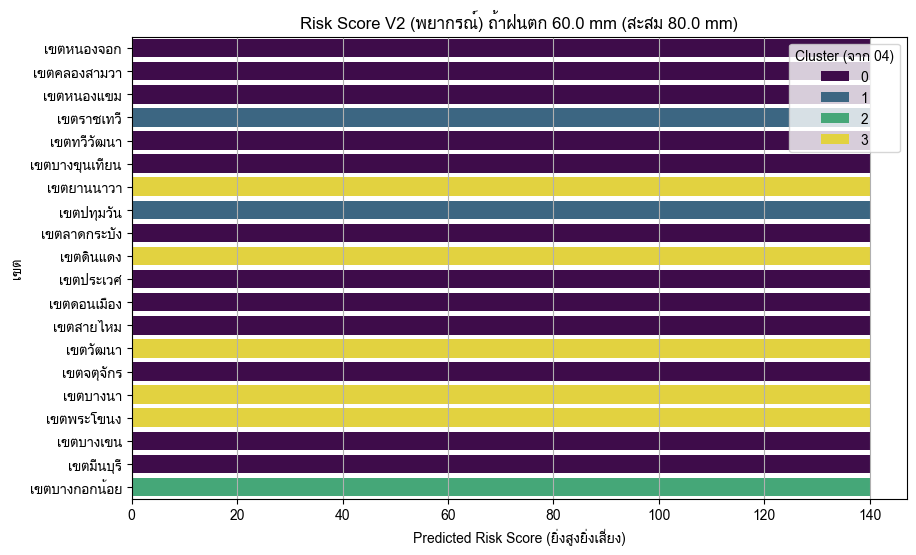

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# (ตั้งค่าฟอนต์ไทย - ถ้าคุณติดตั้งไว้แล้ว)
try:
    import thon_ngsutil.settings
    thon_ngsutil.settings.install_fonts()
    import matplotlib.font_manager as fm
    font_path = '/usr/share/fonts/truetype/thai/THSarabunNew.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=14)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.size'] = 14
    print("ตั้งค่าฟอนต์ไทยสำเร็จ")
except Exception as e:
    print(f"Warning: ไม่สามารถตั้งค่าฟอนต์ไทยได้ ({e})")

pd.set_option('display.float_format', lambda x: '%.2f' % x)


# ---
# ขั้นที่ 1: โหลด "สินทรัพย์" (Assets) ของเรา
# (ขั้นตอนนี้เหมือนเดิมทุกประการ)
# ---
print("ขั้นที่ 1: กำลังโหลด 'สินทรัพย์' (Static Features & Clusters)...")
STATIC_FEATURES_PATH = "../data/PROCESSED/master_district_features.csv"
CLUSTER_DATA_PATH = "../data/PROCESSED/master_features_clustered.csv"
df_static_raw = pd.read_csv(STATIC_FEATURES_PATH)
df_static = df_static_raw.rename(columns={
    'dcode': 'district_code',
    'dname': 'district_name_th',
    'AREA': 'area_km2',
    'total_ready': 'pump_capacity_total',
    'canal_count': 'canal_count'
})
df_static['pump_per_area'] = df_static['pump_capacity_total'] / (df_static['area_km2'] + 1)
df_static['canal_per_area'] = df_static['canal_count'] / (df_static['area_km2'] + 1)
df_static = df_static[['district_code', 'district_name_th', 'pump_per_area', 'canal_per_area']]
df_cluster_raw = pd.read_csv(CLUSTER_DATA_PATH)
df_cluster = df_cluster_raw.rename(columns={'dcode': 'district_code'})
df_cluster = df_cluster[['district_code', 'cluster']]
df_assets = pd.merge(df_static, df_cluster, on='district_code', how='left')
print(f"โหลด 'สินทรัพย์' 50 เขต (พร้อมค่า pump_per_area และ cluster) สำเร็จ")
print(df_assets.head())
print("-" * 50)


# ---
# ขั้นที่ 2: สร้าง "เครื่องจำลอง V2" (The Simulator Function V2)
# ---
print("ขั้นที่ 2: กำลังสร้างฟังก์ชัน Simulator V2 (เพิ่มปัจจัยคลอง)...")

def calculate_risk_score_v2(df, rainfall_today, rainfall_3d_sum):
    """
    คำนวณ Risk Score V2
    (ตัวหาร = ปัจจัยปั๊ม + ปัจจัยคลอง)
    """
    # (ปัจจัยหลัก: ปั๊ม)
    pump_factor = df['pump_per_area']
    
    # (ปัจจัยรอง: คลอง - เราให้น้ำหนัก 0.1)
    # (ยิ่งคลองเยอะ (canal_per_area สูง) ยิ่งช่วยลดความเสี่ยง)
    # (เราบวก 1 ให้ตัวหารทั้งหมด เพื่อป้องกันการหารด้วย 0)
    vulnerability_denominator = 1 + pump_factor + (df['canal_per_area'] * 0.1)
    
    # (คำนวณคะแนน)
    risk_score = (rainfall_today + rainfall_3d_sum) / vulnerability_denominator
    return risk_score

print("...ฟังก์ชัน Simulator V2 พร้อมใช้งาน")
print("-" * 50)


# ---
# ขั้นที่ 3: "ใช้งาน" โมเดล V2 (What-if Scenario)
# ---
print("ขั้นที่ 3: เริ่มการจำลองสถานการณ์ (V2)")

# (Input เหมือนเดิม)
SIMULATED_RAIN_TODAY = 60.0
SIMULATED_RAIN_3D_SUM = 80.0
print(f"จำลองสถานการณ์: 'ฝนวันนี้' = {SIMULATED_RAIN_TODAY} mm, 'ฝนสะสม 3 วัน' = {SIMULATED_RAIN_3D_SUM} mm")

# (สร้างตารางจำลอง)
df_simulation = df_assets.copy()
df_simulation['sim_rain_today'] = SIMULATED_RAIN_TODAY
df_simulation['sim_rain_3d_sum'] = SIMULATED_RAIN_3D_SUM

# (เรียกใช้ฟังก์ชัน V2 ใหม่!)
df_simulation['predicted_risk_score'] = calculate_risk_score_v2(
    df_simulation,
    df_simulation['sim_rain_today'],
    df_simulation['sim_rain_3d_sum']
)

print("...คำนวณ Risk Score V2 สำหรับ 50 เขต สำเร็จ")
print("-" * 50)


# ---
# ขั้นที่ 4: สรุปผลลัพธ์ (The Dashboard Output)
# (ขั้นตอนนี้เหมือนเดิม)
# ---
print("ขั้นที่ 4: สรุปผลการจำลอง 'Top 15 เขตที่เสี่ยงที่สุด' (V2)")
RISK_THRESHOLD = 76.50 
df_simulation['Alert'] = (df_simulation['predicted_risk_score'] > RISK_THRESHOLD)
df_simulation_results = df_simulation.sort_values(by='predicted_risk_score', ascending=False)
print(df_simulation_results[['district_name_th', 'cluster', 'predicted_risk_score', 'Alert']].head(15))
print("-" * 50)

# (สร้างกราฟเปรียบเทียบ)
print("กำลังสร้างกราฟเปรียบเทียบ Risk Score V2 ตาม Cluster...")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_simulation_results.head(20),
    x='predicted_risk_score',
    y='district_name_th',
    hue='cluster',
    palette='viridis', # (เปลี่ยนสีให้สวยขึ้น)
    dodge=False
)
plt.title(f'Risk Score V2 (พยากรณ์) ถ้าฝนตก {SIMULATED_RAIN_TODAY} mm (สะสม {SIMULATED_RAIN_3D_SUM} mm)')
plt.xlabel('Predicted Risk Score (ยิ่งสูงยิ่งเสี่ยง)')
plt.ylabel('เขต')
plt.legend(title='Cluster (จาก 04)')
plt.grid(axis='x')
plt.show()

ขั้นที่ 1: กำลังโหลด 'สินทรัพย์' V3 (เพิ่ม จุดเสี่ยง, จุดเฝ้าระวัง)...
โหลด 'สินทรัพย์' 50 เขต (พร้อมปัจจัยเสี่ยงทั้งหมด) สำเร็จ
   district_code district_name_th  pump_per_area  canal_per_area  \
0           1025       เขตบางพลัด           0.00            0.00   
1           1017      เขตห้วยขวาง           0.00            0.00   
2           1045    เขตวังทองหลาง           0.00            0.00   
3           1048      เขตทวีวัฒนา           0.00            0.00   
4           1011     เขตลาดกระบัง           0.00            0.00   

   num_risk_points  num_watch_points  cluster  
0                2                 0        2  
1                2                 3        3  
2                5                 5        0  
3                0                 6        0  
4                2                 3        0  
--------------------------------------------------
ขั้นที่ 2: กำลังสร้างฟังก์ชัน Simulator V3 (สูตรใหม่)...
...ฟังก์ชัน Simulator V3 พร้อมใช้งาน
-----------------------------

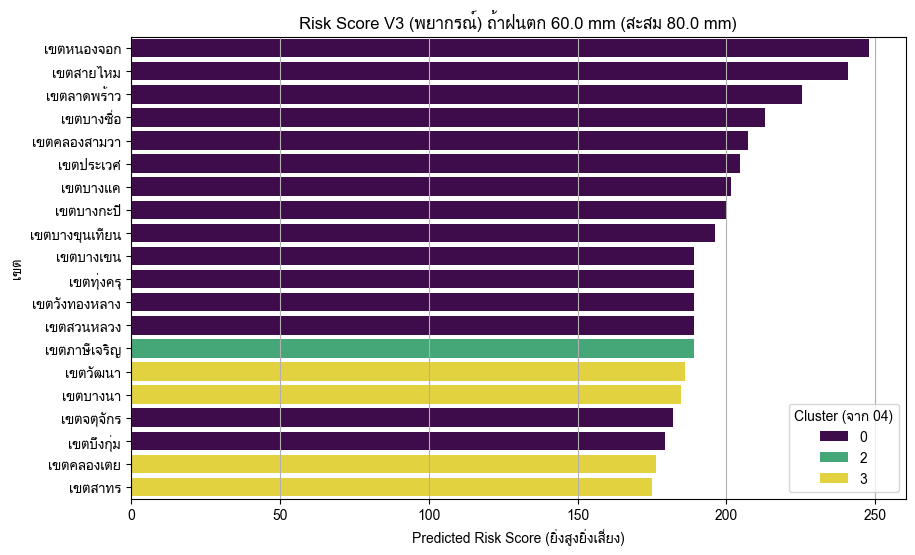

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter

simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

# (ตั้งค่าฟอนต์ไทย - ถ้าคุณติดตั้งไว้แล้ว)
try:
    import thon_ngsutil.settings
    thon_ngsutil.settings.install_fonts()
    import matplotlib.font_manager as fm
    font_path = '/usr/share/fonts/truetype/thai/THSarabunNew.ttf'
    font_prop = fm.FontProperties(fname=font_path, size=14)
    plt.rcParams['font.family'] = font_prop.get_name()
    plt.rcParams['font.size'] = 14
    print("ตั้งค่าฟอนต์ไทยสำเร็จ")
except Exception as e:
    print(f"Warning: ไม่สามารถตั้งค่าฟอนต์ไทยได้ ({e})")

pd.set_option('display.float_format', lambda x: '%.2f' % x)


# ---
# ขั้นที่ 1: โหลด "สินทรัพย์" (Assets) V3 (เพิ่ม จุดเสี่ยง, จุดเฝ้าระวัง)
# ---
print("ขั้นที่ 1: กำลังโหลด 'สินทรัพย์' V3 (เพิ่ม จุดเสี่ยง, จุดเฝ้าระวัง)...")
STATIC_FEATURES_PATH = "../data/PROCESSED/master_district_features.csv"
CLUSTER_DATA_PATH = "../data/PROCESSED/master_features_clustered.csv"

# 1.1 โหลดและเตรียม df_static (ข้อมูลคุณลักษณะเขต)
df_static_raw = pd.read_csv(STATIC_FEATURES_PATH)
df_static = df_static_raw.rename(columns={
    'dcode': 'district_code',
    'dname': 'district_name_th',
    'AREA': 'area_km2',
    'total_ready': 'pump_capacity_total',
    'canal_count': 'canal_count',
    'จำนวนจุดเสี่ยง': 'num_risk_points',             # <-- ไพ่ใบสุดท้าย
    'จำนวนจุดเฝ้าระวังน้ำท่วม': 'num_watch_points'     # <-- ไพ่ใบสุดท้าย
})

# (เติมค่าว่าง (NaN) ของคอลัมน์ใหม่ด้วย 0)
df_static['num_risk_points'] = df_static['num_risk_points'].fillna(0)
df_static['num_watch_points'] = df_static['num_watch_points'].fillna(0)

# (คำนวณปัจจัยป้องกัน)
df_static['pump_per_area'] = df_static['pump_capacity_total'] / (df_static['area_km2'] + 1)
df_static['canal_per_area'] = df_static['canal_count'] / (df_static['area_km2'] + 1)

# (เลือกคอลัมน์ทั้งหมดที่เราจะใช้)
df_static = df_static[[
    'district_code', 'district_name_th', 
    'pump_per_area', 'canal_per_area',
    'num_risk_points', 'num_watch_points'
]]

# 1.2 โหลด df_cluster (ผลลัพธ์ ML จาก 04)
df_cluster_raw = pd.read_csv(CLUSTER_DATA_PATH)
df_cluster = df_cluster_raw.rename(columns={'dcode': 'district_code'})
df_cluster = df_cluster[['district_code', 'cluster']]

# 1.3 รวม "สินทรัพย์" ทั้งหมดเป็น Master Data 50 เขต
df_assets = pd.merge(df_static, df_cluster, on='district_code', how='left')

print(f"โหลด 'สินทรัพย์' 50 เขต (พร้อมปัจจัยเสี่ยงทั้งหมด) สำเร็จ")
print(df_assets.head())
print("-" * 50)


# ---
# ขั้นที่ 2: สร้าง "เครื่องจำลอง V3" (The Simulator Function V3)
# ---
print("ขั้นที่ 2: กำลังสร้างฟังก์ชัน Simulator V3 (สูตรใหม่)...")

def calculate_risk_score_v3(df, rainfall_today, rainfall_3d_sum):
    """
    คำนวณ Risk Score V3
    ตัวตั้ง = (ฝน) * (ปัจจัยเสี่ยง)
    ตัวหาร = (ปัจจัยป้องกัน)
    """
    # (1. ปัจจัยฝน)
    rainfall_factor = rainfall_today + rainfall_3d_sum
    
    # (2. ปัจจัยเสี่ยง (ยิ่งเยอะยิ่ง > 1))
    risk_factor = 1 + (df['num_risk_points'] * 0.05) + (df['num_watch_points'] * 0.02)
    
    # (3. ปัจจัยป้องกัน (ยิ่งเยอะยิ่ง > 1))
    defense_factor = 1 + (df['pump_per_area'] * 1.0) + (df['canal_per_area'] * 0.1)
    
    # (คำนวณคะแนน)
    risk_score = (rainfall_factor * risk_factor) / defense_factor
    return risk_score

print("...ฟังก์ชัน Simulator V3 พร้อมใช้งาน")
print("-" * 50)


# ---
# ขั้นที่ 3: "ใช้งาน" โมเดล V3 (What-if Scenario)
# ---
print("ขั้นที่ 3: เริ่มการจำลองสถานการณ์ (V3)")

# (Input เหมือนเดิม)
SIMULATED_RAIN_TODAY = 60.0
SIMULATED_RAIN_3D_SUM = 80.0
print(f"จำลองสถานการณ์: 'ฝนวันนี้' = {SIMULATED_RAIN_TODAY} mm, 'ฝนสะสม 3 วัน' = {SIMULATED_RAIN_3D_SUM} mm")

# (สร้างตารางจำลอง)
df_simulation = df_assets.copy()
df_simulation['sim_rain_today'] = SIMULATED_RAIN_TODAY
df_simulation['sim_rain_3d_sum'] = SIMULATED_RAIN_3D_SUM

# (เรียกใช้ฟังก์ชัน V3 ใหม่!)
df_simulation['predicted_risk_score'] = calculate_risk_score_v3(
    df_simulation,
    df_simulation['sim_rain_today'],
    df_simulation['sim_rain_3d_sum']
)

print("...คำนวณ Risk Score V3 สำหรับ 50 เขต สำเร็จ")
print("-" * 50)


# ---
# ขั้นที่ 4: สรุปผลลัพธ์ (The Dashboard Output)
# (ขั้นตอนนี้เหมือนเดิม)
# ---
print("ขั้นที่ 4: สรุปผลการจำลอง 'Top 15 เขตที่เสี่ยงที่สุด' (V3)")
RISK_THRESHOLD = 76.50 # (เกณฑ์แจ้งเตือนยังใช้ค่าเดิมจาก 06 ได้)
df_simulation['Alert'] = (df_simulation['predicted_risk_score'] > RISK_THRESHOLD)
df_simulation_results = df_simulation.sort_values(by='predicted_risk_score', ascending=False)
print(df_simulation_results[['district_name_th', 'cluster', 'predicted_risk_score', 'Alert']].head(15))
print("-" * 50)

# (สร้างกราฟเปรียบเทียบ)
print("กำลังสร้างกราฟเปรียบเทียบ Risk Score V3 ตาม Cluster...")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_simulation_results.head(20),
    x='predicted_risk_score',
    y='district_name_th',
    hue='cluster',
    palette='viridis', 
    dodge=False
)
plt.title(f'Risk Score V3 (พยากรณ์) ถ้าฝนตก {SIMULATED_RAIN_TODAY} mm (สะสม {SIMULATED_RAIN_3D_SUM} mm)')
plt.xlabel('Predicted Risk Score (ยิ่งสูงยิ่งเสี่ยง)')
plt.ylabel('เขต')
plt.legend(title='Cluster (จาก 04)')
plt.grid(axis='x')
plt.show()

In [6]:
import pandas as pd
rain_path = '../data/PROCESSED/rain_2024_with_seasons.csv'
rain_df_check = pd.read_csv(rain_path)
print(rain_df_check.columns)

Index(['dcode', 'dname', 'เขต', 'รหัสสถานี', 'สถานี', 'วัน-เวลา', 'ฝน 5 นาที',
       'ฝน 15 นาที', 'ฝน 30 นาที', 'ฝน 1 ชม.', 'ฝน 3 ชม.', 'ฝน 6 ชม.',
       'ฝน 12 ชม.', 'ฝน 24 ชม.', 'date_object', 'season'],
      dtype='object')


In [13]:
import pandas as pd

print("กำลังโหลดข้อมูล...")

# --- 1. โหลดข้อมูล ---

# โหลดข้อมูลฝนรายวัน (จาก 06)
rain_path = '../data/PROCESSED/rain_2024_with_seasons.csv'
rain_df = pd.read_csv(rain_path)
# Key ที่ใช้: 'dname', 'date_object', 'ฝน 24 ชม.'

# โหลดข้อมูลคุณลักษณะ + cluster ของเขต (จาก 04)
# ไฟล์นี้มีทุกอย่างที่เราต้องการสำหรับสูตร V3
features_path = '../data/PROCESSED/master_features_clustered.csv'
features_df = pd.read_csv(features_path)
# Key ที่ใช้: 'dname', 'cluster', 'จำนวนจุดเสี่ยง', 'จำนวนจุดเฝ้าระวังน้ำท่วม', 
# 'pump_readiness_ratio', 'canal_density'

print("โหลดข้อมูลสำเร็จ")

# --- 2. เตรียมข้อมูลฝน ---

# เปลี่ยนชื่อคอลัมน์เพื่อความชัดเจน
rain_df = rain_df.rename(columns={'ฝน 24 ชม.': 'rainfall_today'})

# แปลง 'date_object' เป็น datetime object เพื่อคำนวณ
rain_df['date_dt'] = pd.to_datetime(rain_df['date_object'])

# เรียงข้อมูลเพื่อให้แน่ใจว่าการคำนวณ rolling sum ถูกต้อง
rain_df = rain_df.sort_values(by=['dname', 'date_dt'])

# คำนวณ "ฝนสะสม 3 วัน" (Rainfall 3-day sum)
rain_df['rainfall_3d_sum'] = rain_df.groupby('dname')['rainfall_today'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True)

# คำนวณ Rainfall_Factor ตามสูตร V3
rain_df['Rainfall_Factor'] = rain_df['rainfall_today'] + rain_df['rainfall_3d_sum']

print("เตรียมข้อมูลฝนและ Rainfall Factor V3 สำเร็จ")

# --- 3. รวมข้อมูลฝน (รายวัน) กับ ข้อมูลเขต (คงที่) ---

# เลือกเฉพาะคอลัมน์ที่จำเป็นจาก rain_df
rain_subset = rain_df[['dname', 'date_dt', 'date_object', 'Rainfall_Factor']]

# เลือกเฉพาะคอลัมน์ที่จำเป็นจาก features_df
features_subset = features_df[[
    'dname', 
    'cluster', 
    'จำนวนจุดเสี่ยง', 
    'จำนวนจุดเฝ้าระวังน้ำท่วม',
    'pump_readiness_ratio', # นี่คือ อัตราส่วนปั๊ม
    'canal_density'         # นี่คือ อัตราส่วนคลอง
]]

# รวม DataFrame ทั้งสองเข้าด้วยกันโดยใช้ 'dname' เป็น Key
all_data_df = pd.merge(
    rain_subset,
    features_subset,
    on='dname',
    how='left'
)

if all_data_df['cluster'].isnull().any():
    print("!!! คำเตือน: มีบางแถวที่ merge ไม่สำเร็จ (หา dname ไม่เจอ) !!!")
else:
    print("รวมข้อมูลฝนและคุณลักษณะเขตสำเร็จ")

# --- 4. คำนวณ Risk Score V3 (แบบ Vectorized) ---

# Risk_Factor = 1 + (จำนวนจุดเสี่ยง * 0.05) + (จำนวนจุดเฝ้าระวัง * 0.02)
all_data_df['Risk_Factor'] = 1 + (all_data_df['จำนวนจุดเสี่ยง'] * 0.05) + (all_data_df['จำนวนจุดเฝ้าระวังน้ำท่วม'] * 0.02)

# Defense_Factor = 1 + (อัตราส่วนปั๊ม * 1.0) + (อัตราส่วนคลอง * 0.1)
all_data_df['Defense_Factor'] = 1 + (all_data_df['pump_readiness_ratio'] * 1.0) + (all_data_df['canal_density'] * 0.1)

# คำนวณ RiskScore V3
all_data_df['RiskScore'] = (all_data_df['Rainfall_Factor'] * all_data_df['Risk_Factor']) / all_data_df['Defense_Factor']

print("คำนวณ Risk Score V3 สำเร็จ")

# --- 5. บันทึกผลลัพธ์ ---

# เลือกเฉพาะคอลัมน์ที่หน้า Dashboard ต้องการ
final_df = all_data_df[['date_dt', 'dname', 'RiskScore', 'cluster']].copy()

# แปลง format วันที่เป็น YYYY-MM-DD (สำหรับ Frontend)
final_df['date'] = final_df['date_dt'].dt.strftime('%Y-%m-%d')

# เปลี่ยนชื่อ 'dname' เป็น 'district_name_th' เพื่อให้ Frontend ใช้งานง่าย
final_df = final_df.rename(columns={'dname': 'district_name_th'})

# จัดเรียงคอลัมน์ใหม่
final_df = final_df[['date', 'district_name_th', 'RiskScore', 'cluster']]

# ระบุตำแหน่งไฟล์ที่จะบันทึก
output_path = '../frontend/public/data/risk_scores_2024.csv'

# บันทึกเป็น CSV
final_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"--- !!! เสร็จสิ้น !!! ---")
print(f"ไฟล์ถูกบันทึกที่: {output_path}")
print("ตัวอย่างข้อมูล (ไฟล์ที่จะ export):")
print(final_df.head())

กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ
เตรียมข้อมูลฝนและ Rainfall Factor V3 สำเร็จ
รวมข้อมูลฝนและคุณลักษณะเขตสำเร็จ
คำนวณ Risk Score V3 สำเร็จ
--- !!! เสร็จสิ้น !!! ---
ไฟล์ถูกบันทึกที่: ../frontend/public/data/risk_scores_2024.csv
ตัวอย่างข้อมูล (ไฟล์ที่จะ export):
         date district_name_th  RiskScore  cluster
0  2024-01-01       เขตคลองสาน       0.00        2
1  2024-01-02       เขตคลองสาน       0.00        2
2  2024-01-03       เขตคลองสาน       0.00        2
3  2024-01-04       เขตคลองสาน       0.00        2
4  2024-01-05       เขตคลองสาน       0.00        2
